# Demo: Building CNN Autoencoders in Pytorch (MNIST)

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/convAE.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Convolutional Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [2]:
data_dir = '../dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

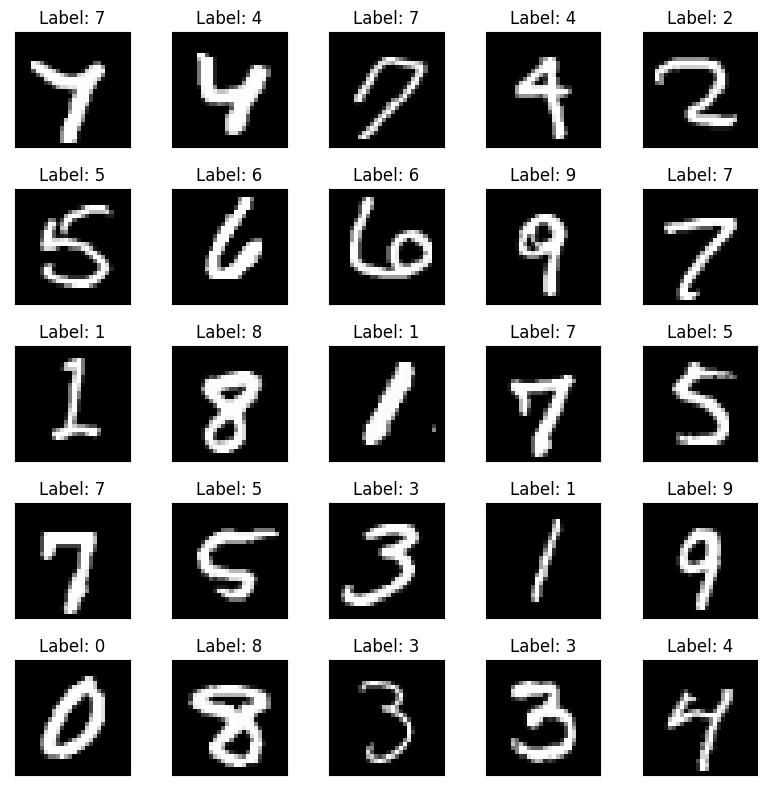

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1. Define Convolutional Autoencoder

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        
        # Apply convolutions
        x = self.encoder_cnn(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 2. Initialize Loss function and the optimizer
*Note that "d" is the size of a latent space*

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [9]:
### Some examples

# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape, ', encoded image:', img_enc)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4]) , encoded image: tensor([[-0.0388, -0.0502,  0.0386, -0.0435]], grad_fn=<AddmmBackward0>)
Decoded image shape: torch.Size([1, 1, 28, 28])


In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
print(encoder)
print(decoder)

Selected device: cuda
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTr

## 3. Train and evaluate model

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        # Encode data
        encoded_data = encoder(image_batch)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            
            # Encode data
            encoded_data = encoder(image_batch)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

In [13]:
def plot_ae_outputs(encoder,decoder,n=5):
    
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        
      ax = plt.subplot(2,n,i+1)
    
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
        
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
    
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
        
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253401
	 partial train loss (single batch): 0.246334
	 partial train loss (single batch): 0.239922
	 partial train loss (single batch): 0.236101
	 partial train loss (single batch): 0.231711
	 partial train loss (single batch): 0.228092
	 partial train loss (single batch): 0.225367
	 partial train loss (single batch): 0.223137
	 partial train loss (single batch): 0.220313
	 partial train loss (single batch): 0.218190
	 partial train loss (single batch): 0.215213
	 partial train loss (single batch): 0.213487
	 partial train loss (single batch): 0.211212
	 partial train loss (single batch): 0.208917
	 partial train loss (single batch): 0.207479
	 partial train loss (single batch): 0.205480
	 partial train loss (single batch): 0.203601
	 partial train loss (single batch): 0.201005
	 partial train loss (single batch): 0.199614
	 partial train loss (single batch): 0.196952
	 partial train loss (single batch): 0.195857
	 partial train loss (single batch

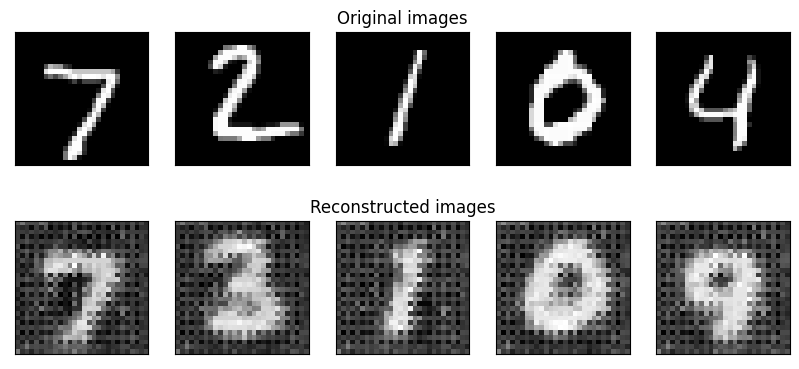

	 partial train loss (single batch): 0.065646
	 partial train loss (single batch): 0.064156
	 partial train loss (single batch): 0.065756
	 partial train loss (single batch): 0.065099
	 partial train loss (single batch): 0.064254
	 partial train loss (single batch): 0.064124
	 partial train loss (single batch): 0.064578
	 partial train loss (single batch): 0.063110
	 partial train loss (single batch): 0.062325
	 partial train loss (single batch): 0.063799
	 partial train loss (single batch): 0.063181
	 partial train loss (single batch): 0.062469
	 partial train loss (single batch): 0.061936
	 partial train loss (single batch): 0.063146
	 partial train loss (single batch): 0.061613
	 partial train loss (single batch): 0.062415
	 partial train loss (single batch): 0.061884
	 partial train loss (single batch): 0.061056
	 partial train loss (single batch): 0.061233
	 partial train loss (single batch): 0.061126
	 partial train loss (single batch): 0.061332
	 partial train loss (single batch

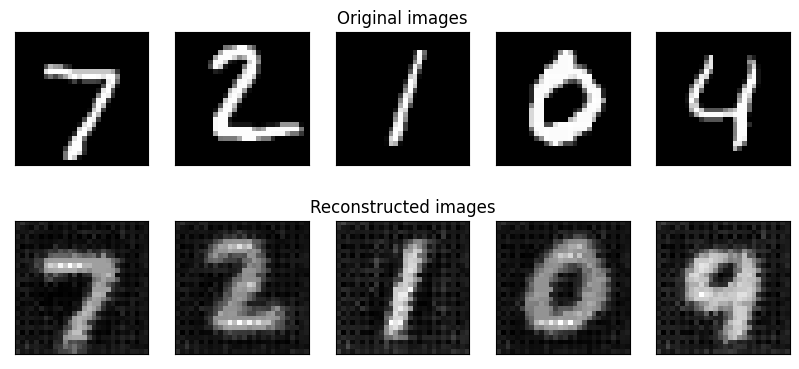

	 partial train loss (single batch): 0.047127
	 partial train loss (single batch): 0.046182
	 partial train loss (single batch): 0.048244
	 partial train loss (single batch): 0.047674
	 partial train loss (single batch): 0.046778
	 partial train loss (single batch): 0.046616
	 partial train loss (single batch): 0.047548
	 partial train loss (single batch): 0.046186
	 partial train loss (single batch): 0.045647
	 partial train loss (single batch): 0.046987
	 partial train loss (single batch): 0.046567
	 partial train loss (single batch): 0.046328
	 partial train loss (single batch): 0.045337
	 partial train loss (single batch): 0.047294
	 partial train loss (single batch): 0.045917
	 partial train loss (single batch): 0.046663
	 partial train loss (single batch): 0.046313
	 partial train loss (single batch): 0.045543
	 partial train loss (single batch): 0.045901
	 partial train loss (single batch): 0.045856
	 partial train loss (single batch): 0.046083
	 partial train loss (single batch

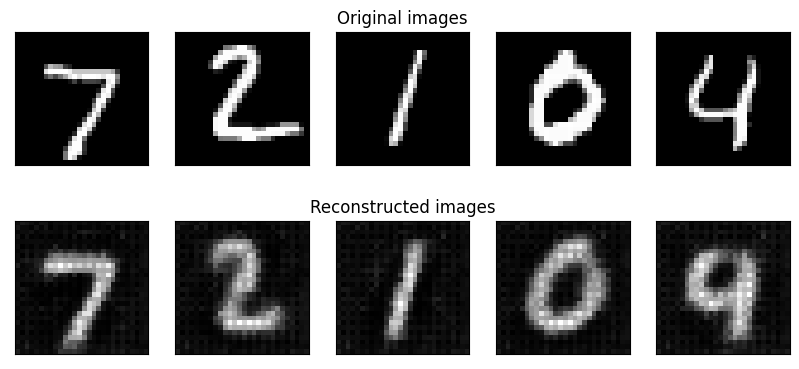

	 partial train loss (single batch): 0.037717
	 partial train loss (single batch): 0.037695
	 partial train loss (single batch): 0.039970
	 partial train loss (single batch): 0.038978
	 partial train loss (single batch): 0.038167
	 partial train loss (single batch): 0.037831
	 partial train loss (single batch): 0.039319
	 partial train loss (single batch): 0.037874
	 partial train loss (single batch): 0.037289
	 partial train loss (single batch): 0.038203
	 partial train loss (single batch): 0.037902
	 partial train loss (single batch): 0.037712
	 partial train loss (single batch): 0.036972
	 partial train loss (single batch): 0.038928
	 partial train loss (single batch): 0.037897
	 partial train loss (single batch): 0.037852
	 partial train loss (single batch): 0.038614
	 partial train loss (single batch): 0.037293
	 partial train loss (single batch): 0.037370
	 partial train loss (single batch): 0.037868
	 partial train loss (single batch): 0.038043
	 partial train loss (single batch

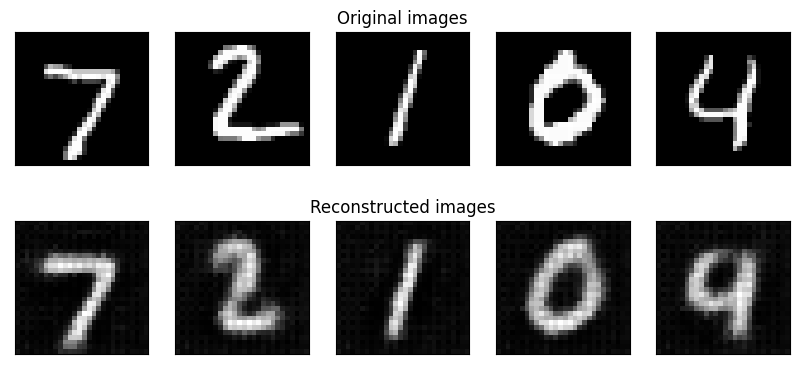

	 partial train loss (single batch): 0.033099
	 partial train loss (single batch): 0.033374
	 partial train loss (single batch): 0.035814
	 partial train loss (single batch): 0.034716
	 partial train loss (single batch): 0.033698
	 partial train loss (single batch): 0.033381
	 partial train loss (single batch): 0.035342
	 partial train loss (single batch): 0.033701
	 partial train loss (single batch): 0.033058
	 partial train loss (single batch): 0.034389
	 partial train loss (single batch): 0.033631
	 partial train loss (single batch): 0.033348
	 partial train loss (single batch): 0.032644
	 partial train loss (single batch): 0.034933
	 partial train loss (single batch): 0.033602
	 partial train loss (single batch): 0.033583
	 partial train loss (single batch): 0.034819
	 partial train loss (single batch): 0.033099
	 partial train loss (single batch): 0.033265
	 partial train loss (single batch): 0.033915
	 partial train loss (single batch): 0.033837
	 partial train loss (single batch

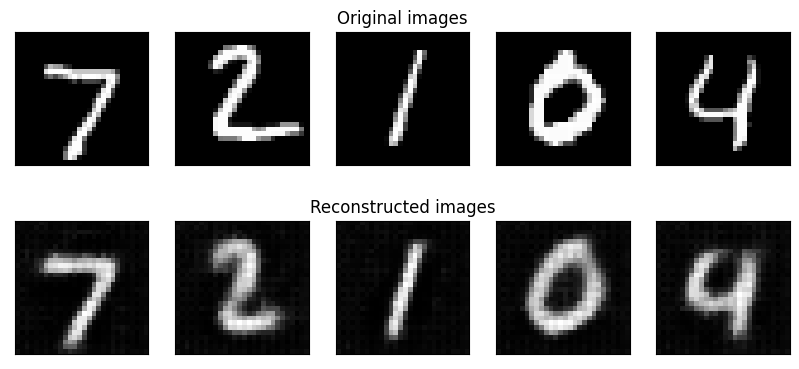

	 partial train loss (single batch): 0.031115
	 partial train loss (single batch): 0.031547
	 partial train loss (single batch): 0.034068
	 partial train loss (single batch): 0.032791
	 partial train loss (single batch): 0.031948
	 partial train loss (single batch): 0.031523
	 partial train loss (single batch): 0.033779
	 partial train loss (single batch): 0.031889
	 partial train loss (single batch): 0.030987
	 partial train loss (single batch): 0.032661
	 partial train loss (single batch): 0.031748
	 partial train loss (single batch): 0.031377
	 partial train loss (single batch): 0.030792
	 partial train loss (single batch): 0.033157
	 partial train loss (single batch): 0.031570
	 partial train loss (single batch): 0.031815
	 partial train loss (single batch): 0.032972
	 partial train loss (single batch): 0.031370
	 partial train loss (single batch): 0.031427
	 partial train loss (single batch): 0.032238
	 partial train loss (single batch): 0.032194
	 partial train loss (single batch

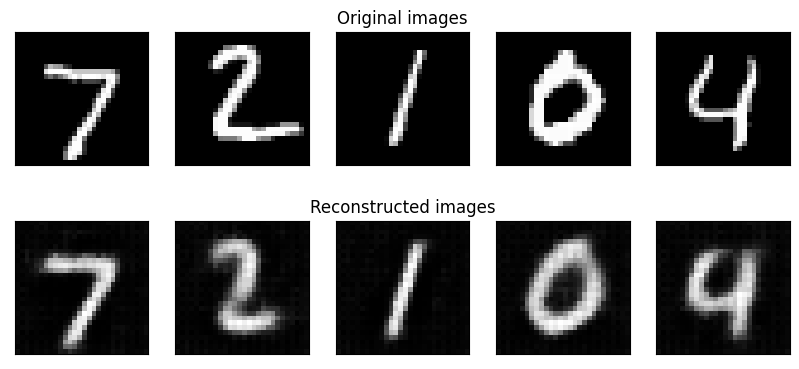

	 partial train loss (single batch): 0.029974
	 partial train loss (single batch): 0.030433
	 partial train loss (single batch): 0.033030
	 partial train loss (single batch): 0.031613
	 partial train loss (single batch): 0.030943
	 partial train loss (single batch): 0.030530
	 partial train loss (single batch): 0.032876
	 partial train loss (single batch): 0.030953
	 partial train loss (single batch): 0.029881
	 partial train loss (single batch): 0.031833
	 partial train loss (single batch): 0.030954
	 partial train loss (single batch): 0.030282
	 partial train loss (single batch): 0.029632
	 partial train loss (single batch): 0.032003
	 partial train loss (single batch): 0.030268
	 partial train loss (single batch): 0.030863
	 partial train loss (single batch): 0.031962
	 partial train loss (single batch): 0.030111
	 partial train loss (single batch): 0.030402
	 partial train loss (single batch): 0.031262
	 partial train loss (single batch): 0.031105
	 partial train loss (single batch

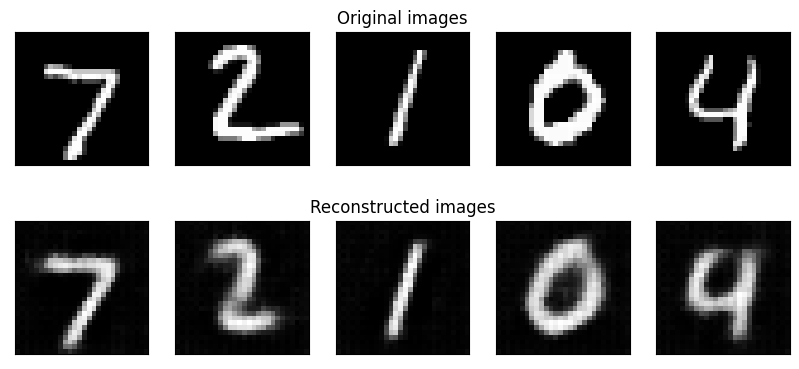

	 partial train loss (single batch): 0.029144
	 partial train loss (single batch): 0.029825
	 partial train loss (single batch): 0.032385
	 partial train loss (single batch): 0.030748
	 partial train loss (single batch): 0.030346
	 partial train loss (single batch): 0.029816
	 partial train loss (single batch): 0.032106
	 partial train loss (single batch): 0.030246
	 partial train loss (single batch): 0.029130
	 partial train loss (single batch): 0.031220
	 partial train loss (single batch): 0.030364
	 partial train loss (single batch): 0.029492
	 partial train loss (single batch): 0.028813
	 partial train loss (single batch): 0.031155
	 partial train loss (single batch): 0.029592
	 partial train loss (single batch): 0.030168
	 partial train loss (single batch): 0.031308
	 partial train loss (single batch): 0.029505
	 partial train loss (single batch): 0.029634
	 partial train loss (single batch): 0.030622
	 partial train loss (single batch): 0.030425
	 partial train loss (single batch

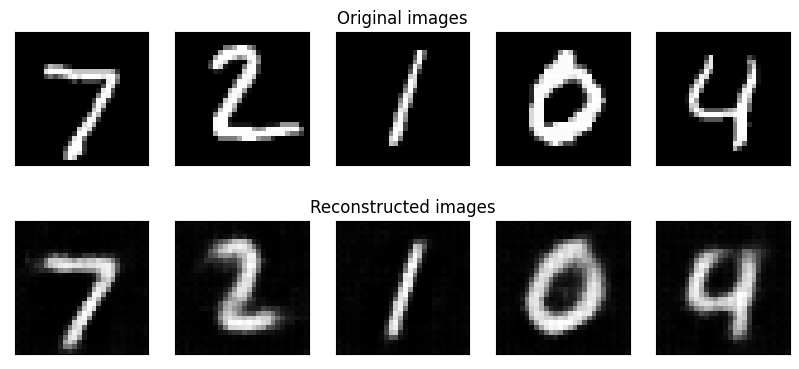

	 partial train loss (single batch): 0.028524
	 partial train loss (single batch): 0.029265
	 partial train loss (single batch): 0.031877
	 partial train loss (single batch): 0.030093
	 partial train loss (single batch): 0.029795
	 partial train loss (single batch): 0.029316
	 partial train loss (single batch): 0.031580
	 partial train loss (single batch): 0.029621
	 partial train loss (single batch): 0.028616
	 partial train loss (single batch): 0.030862
	 partial train loss (single batch): 0.029835
	 partial train loss (single batch): 0.028952
	 partial train loss (single batch): 0.028224
	 partial train loss (single batch): 0.030493
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.029677
	 partial train loss (single batch): 0.030775
	 partial train loss (single batch): 0.028987
	 partial train loss (single batch): 0.029198
	 partial train loss (single batch): 0.030077
	 partial train loss (single batch): 0.029873
	 partial train loss (single batch

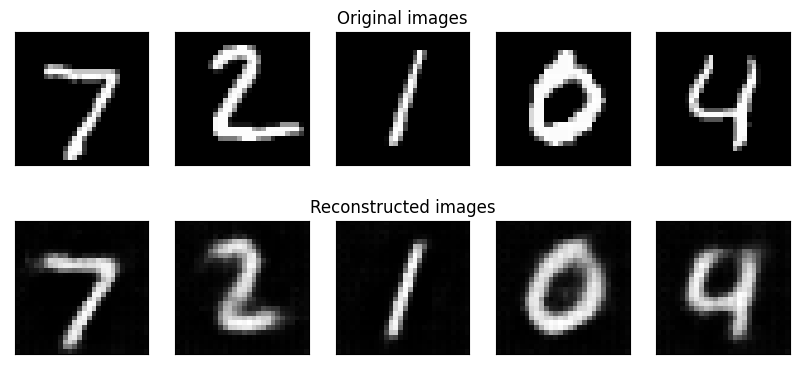

	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.028825
	 partial train loss (single batch): 0.031571
	 partial train loss (single batch): 0.029715
	 partial train loss (single batch): 0.029417
	 partial train loss (single batch): 0.028951
	 partial train loss (single batch): 0.031178
	 partial train loss (single batch): 0.029157
	 partial train loss (single batch): 0.028220
	 partial train loss (single batch): 0.030583
	 partial train loss (single batch): 0.029486
	 partial train loss (single batch): 0.028627
	 partial train loss (single batch): 0.027874
	 partial train loss (single batch): 0.029959
	 partial train loss (single batch): 0.028511
	 partial train loss (single batch): 0.029425
	 partial train loss (single batch): 0.030243
	 partial train loss (single batch): 0.028625
	 partial train loss (single batch): 0.028769
	 partial train loss (single batch): 0.029629
	 partial train loss (single batch): 0.029445
	 partial train loss (single batch

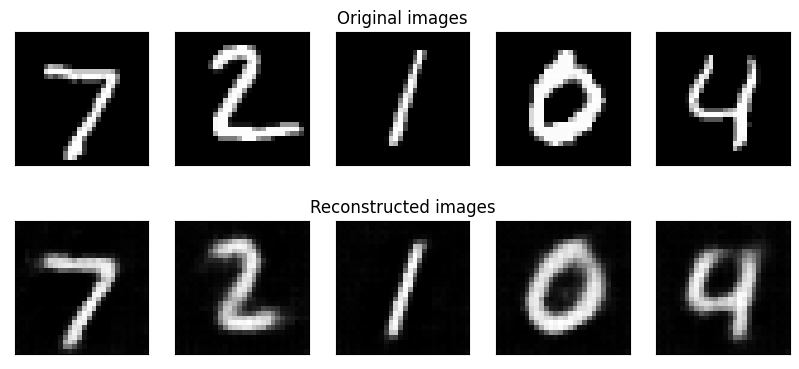

	 partial train loss (single batch): 0.027616
	 partial train loss (single batch): 0.028415
	 partial train loss (single batch): 0.031238
	 partial train loss (single batch): 0.029311
	 partial train loss (single batch): 0.029073
	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.030875
	 partial train loss (single batch): 0.028790
	 partial train loss (single batch): 0.027839
	 partial train loss (single batch): 0.030287
	 partial train loss (single batch): 0.029128
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.029537
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.029065
	 partial train loss (single batch): 0.029810
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.028403
	 partial train loss (single batch): 0.029132
	 partial train loss (single batch): 0.029183
	 partial train loss (single batch

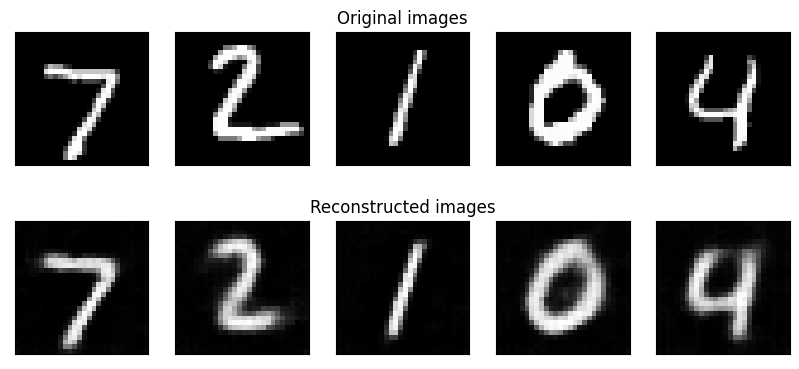

	 partial train loss (single batch): 0.027290
	 partial train loss (single batch): 0.028198
	 partial train loss (single batch): 0.030880
	 partial train loss (single batch): 0.029257
	 partial train loss (single batch): 0.028704
	 partial train loss (single batch): 0.028205
	 partial train loss (single batch): 0.030569
	 partial train loss (single batch): 0.028522
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.030083
	 partial train loss (single batch): 0.028857
	 partial train loss (single batch): 0.028077
	 partial train loss (single batch): 0.027334
	 partial train loss (single batch): 0.029233
	 partial train loss (single batch): 0.027835
	 partial train loss (single batch): 0.028868
	 partial train loss (single batch): 0.029474
	 partial train loss (single batch): 0.027872
	 partial train loss (single batch): 0.028141
	 partial train loss (single batch): 0.028793
	 partial train loss (single batch): 0.028811
	 partial train loss (single batch

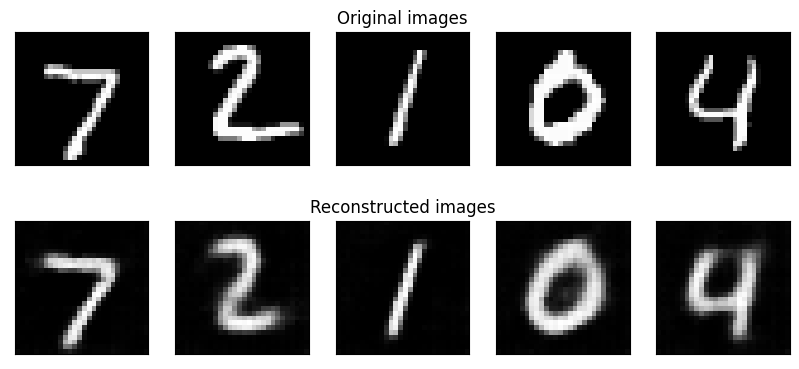

	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.027934
	 partial train loss (single batch): 0.030666
	 partial train loss (single batch): 0.029245
	 partial train loss (single batch): 0.028398
	 partial train loss (single batch): 0.027719
	 partial train loss (single batch): 0.030288
	 partial train loss (single batch): 0.028300
	 partial train loss (single batch): 0.027271
	 partial train loss (single batch): 0.029791
	 partial train loss (single batch): 0.028573
	 partial train loss (single batch): 0.027737
	 partial train loss (single batch): 0.027123
	 partial train loss (single batch): 0.029120
	 partial train loss (single batch): 0.027358
	 partial train loss (single batch): 0.028499
	 partial train loss (single batch): 0.029275
	 partial train loss (single batch): 0.027443
	 partial train loss (single batch): 0.027946
	 partial train loss (single batch): 0.028542
	 partial train loss (single batch): 0.028458
	 partial train loss (single batch

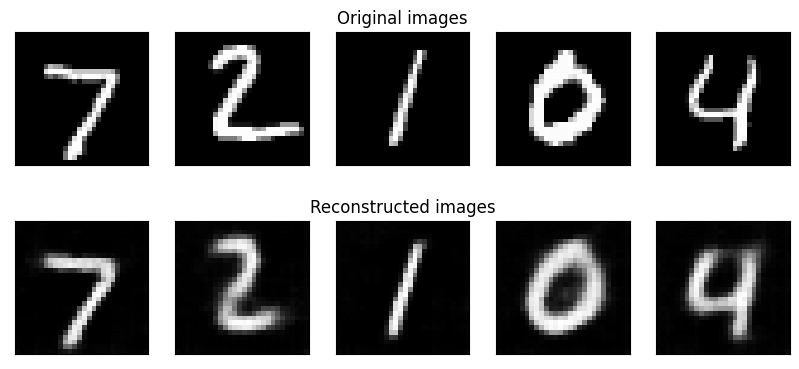

	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.027694
	 partial train loss (single batch): 0.030347
	 partial train loss (single batch): 0.029106
	 partial train loss (single batch): 0.028108
	 partial train loss (single batch): 0.027451
	 partial train loss (single batch): 0.029942
	 partial train loss (single batch): 0.028147
	 partial train loss (single batch): 0.027227
	 partial train loss (single batch): 0.029478
	 partial train loss (single batch): 0.028370
	 partial train loss (single batch): 0.027532
	 partial train loss (single batch): 0.026922
	 partial train loss (single batch): 0.028890
	 partial train loss (single batch): 0.027133
	 partial train loss (single batch): 0.028218
	 partial train loss (single batch): 0.029098
	 partial train loss (single batch): 0.027243
	 partial train loss (single batch): 0.027726
	 partial train loss (single batch): 0.028344
	 partial train loss (single batch): 0.028275
	 partial train loss (single batch

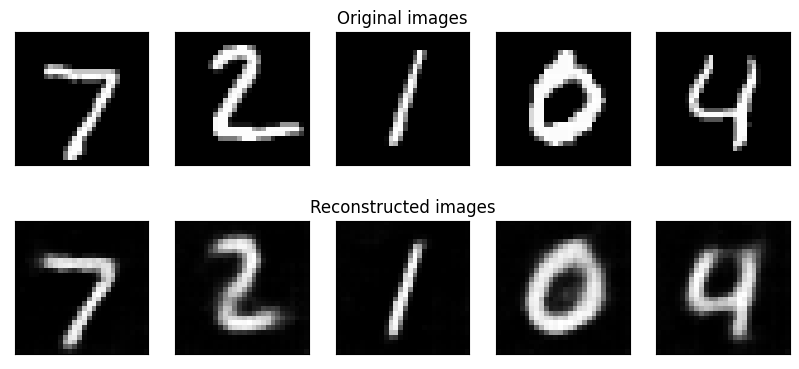

	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.030097
	 partial train loss (single batch): 0.029077
	 partial train loss (single batch): 0.027955
	 partial train loss (single batch): 0.027131
	 partial train loss (single batch): 0.029862
	 partial train loss (single batch): 0.028069
	 partial train loss (single batch): 0.027023
	 partial train loss (single batch): 0.029373
	 partial train loss (single batch): 0.028277
	 partial train loss (single batch): 0.027290
	 partial train loss (single batch): 0.026794
	 partial train loss (single batch): 0.028685
	 partial train loss (single batch): 0.026931
	 partial train loss (single batch): 0.027998
	 partial train loss (single batch): 0.028932
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.027497
	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.028074
	 partial train loss (single batch

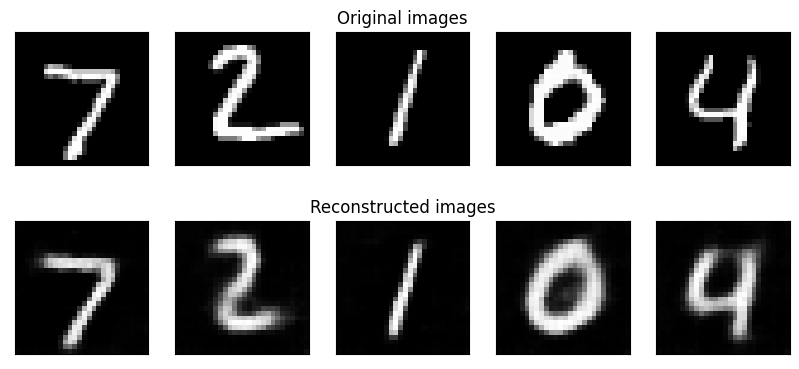

	 partial train loss (single batch): 0.026662
	 partial train loss (single batch): 0.027465
	 partial train loss (single batch): 0.029866
	 partial train loss (single batch): 0.028923
	 partial train loss (single batch): 0.027765
	 partial train loss (single batch): 0.026925
	 partial train loss (single batch): 0.029620
	 partial train loss (single batch): 0.027831
	 partial train loss (single batch): 0.026776
	 partial train loss (single batch): 0.029112
	 partial train loss (single batch): 0.028098
	 partial train loss (single batch): 0.027079
	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.026732
	 partial train loss (single batch): 0.027765
	 partial train loss (single batch): 0.028721
	 partial train loss (single batch): 0.026814
	 partial train loss (single batch): 0.027378
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.027860
	 partial train loss (single batch

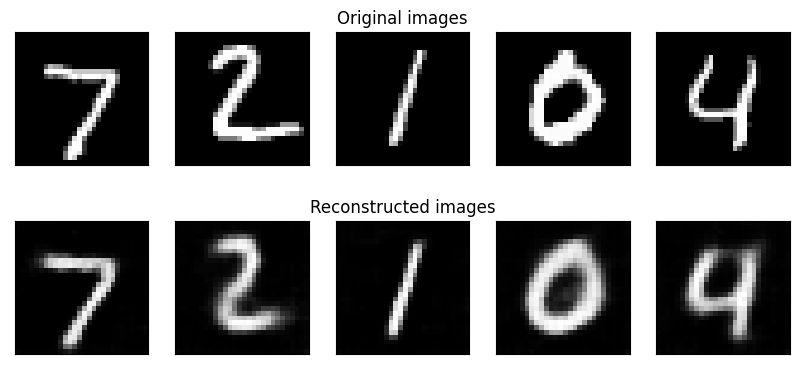

	 partial train loss (single batch): 0.026642
	 partial train loss (single batch): 0.027427
	 partial train loss (single batch): 0.029628
	 partial train loss (single batch): 0.028866
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.026648
	 partial train loss (single batch): 0.029511
	 partial train loss (single batch): 0.027893
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.028913
	 partial train loss (single batch): 0.027963
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.028204
	 partial train loss (single batch): 0.026559
	 partial train loss (single batch): 0.027708
	 partial train loss (single batch): 0.028566
	 partial train loss (single batch): 0.026618
	 partial train loss (single batch): 0.027265
	 partial train loss (single batch): 0.027810
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch

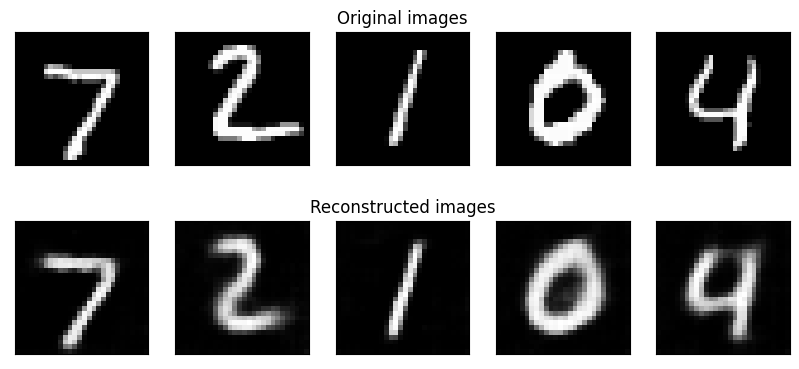

	 partial train loss (single batch): 0.026468
	 partial train loss (single batch): 0.027203
	 partial train loss (single batch): 0.029390
	 partial train loss (single batch): 0.028631
	 partial train loss (single batch): 0.027506
	 partial train loss (single batch): 0.026493
	 partial train loss (single batch): 0.029239
	 partial train loss (single batch): 0.027693
	 partial train loss (single batch): 0.026475
	 partial train loss (single batch): 0.028684
	 partial train loss (single batch): 0.027820
	 partial train loss (single batch): 0.026623
	 partial train loss (single batch): 0.026257
	 partial train loss (single batch): 0.028027
	 partial train loss (single batch): 0.026463
	 partial train loss (single batch): 0.027572
	 partial train loss (single batch): 0.028424
	 partial train loss (single batch): 0.026496
	 partial train loss (single batch): 0.027175
	 partial train loss (single batch): 0.027671
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch

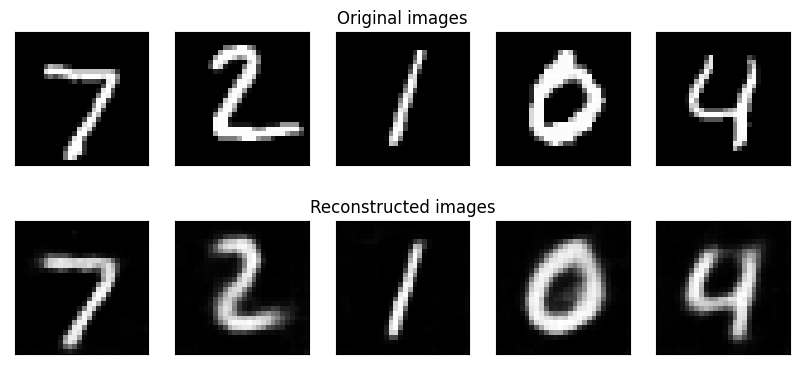

	 partial train loss (single batch): 0.026402
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.029166
	 partial train loss (single batch): 0.028498
	 partial train loss (single batch): 0.027336
	 partial train loss (single batch): 0.026348
	 partial train loss (single batch): 0.029202
	 partial train loss (single batch): 0.027548
	 partial train loss (single batch): 0.026307
	 partial train loss (single batch): 0.028593
	 partial train loss (single batch): 0.027738
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.026070
	 partial train loss (single batch): 0.027901
	 partial train loss (single batch): 0.026389
	 partial train loss (single batch): 0.027440
	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.026323
	 partial train loss (single batch): 0.026976
	 partial train loss (single batch): 0.027531
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch

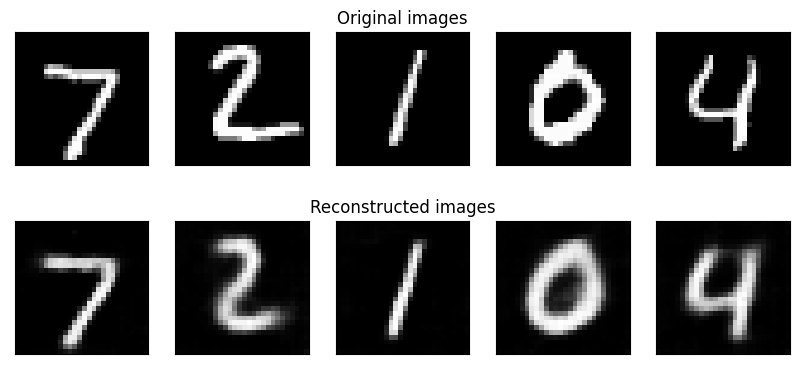

	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.026885
	 partial train loss (single batch): 0.029028
	 partial train loss (single batch): 0.028355
	 partial train loss (single batch): 0.027323
	 partial train loss (single batch): 0.026158
	 partial train loss (single batch): 0.029037
	 partial train loss (single batch): 0.027582
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch): 0.028383
	 partial train loss (single batch): 0.027647
	 partial train loss (single batch): 0.026449
	 partial train loss (single batch): 0.026042
	 partial train loss (single batch): 0.027799
	 partial train loss (single batch): 0.026253
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.028088
	 partial train loss (single batch): 0.026235
	 partial train loss (single batch): 0.026933
	 partial train loss (single batch): 0.027418
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch

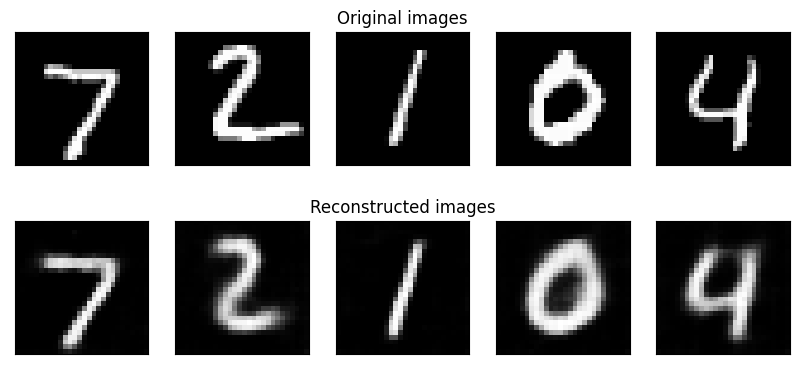

	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.026811
	 partial train loss (single batch): 0.028808
	 partial train loss (single batch): 0.028206
	 partial train loss (single batch): 0.027237
	 partial train loss (single batch): 0.026052
	 partial train loss (single batch): 0.028843
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.026153
	 partial train loss (single batch): 0.028299
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.025874
	 partial train loss (single batch): 0.027552
	 partial train loss (single batch): 0.026152
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.028000
	 partial train loss (single batch): 0.026043
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.027284
	 partial train loss (single batch): 0.027149
	 partial train loss (single batch

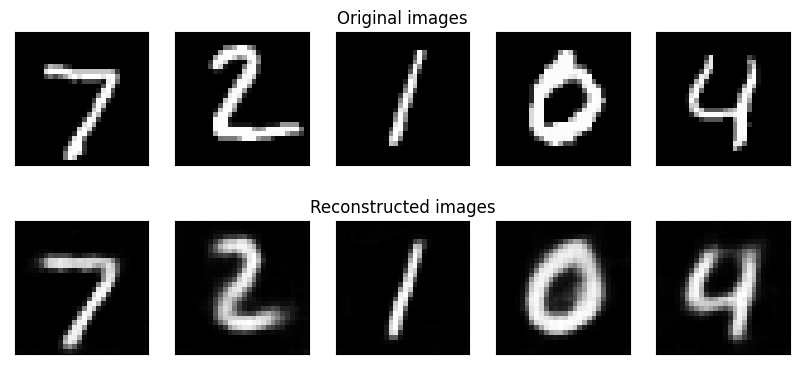

	 partial train loss (single batch): 0.025949
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.028701
	 partial train loss (single batch): 0.028185
	 partial train loss (single batch): 0.027142
	 partial train loss (single batch): 0.025976
	 partial train loss (single batch): 0.028584
	 partial train loss (single batch): 0.027267
	 partial train loss (single batch): 0.025975
	 partial train loss (single batch): 0.028247
	 partial train loss (single batch): 0.027283
	 partial train loss (single batch): 0.026064
	 partial train loss (single batch): 0.025825
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.026042
	 partial train loss (single batch): 0.027187
	 partial train loss (single batch): 0.027915
	 partial train loss (single batch): 0.025976
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.027234
	 partial train loss (single batch): 0.027045
	 partial train loss (single batch

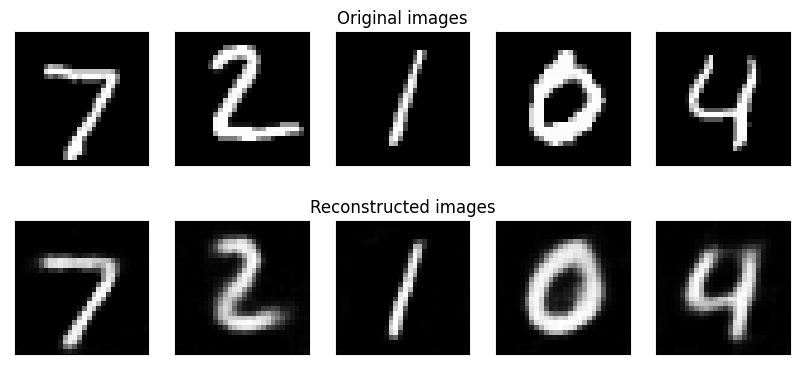

	 partial train loss (single batch): 0.025945
	 partial train loss (single batch): 0.026579
	 partial train loss (single batch): 0.028566
	 partial train loss (single batch): 0.028053
	 partial train loss (single batch): 0.027015
	 partial train loss (single batch): 0.025770
	 partial train loss (single batch): 0.028480
	 partial train loss (single batch): 0.027141
	 partial train loss (single batch): 0.025798
	 partial train loss (single batch): 0.028083
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.025868
	 partial train loss (single batch): 0.025690
	 partial train loss (single batch): 0.027440
	 partial train loss (single batch): 0.025914
	 partial train loss (single batch): 0.027064
	 partial train loss (single batch): 0.027829
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.027211
	 partial train loss (single batch): 0.026940
	 partial train loss (single batch

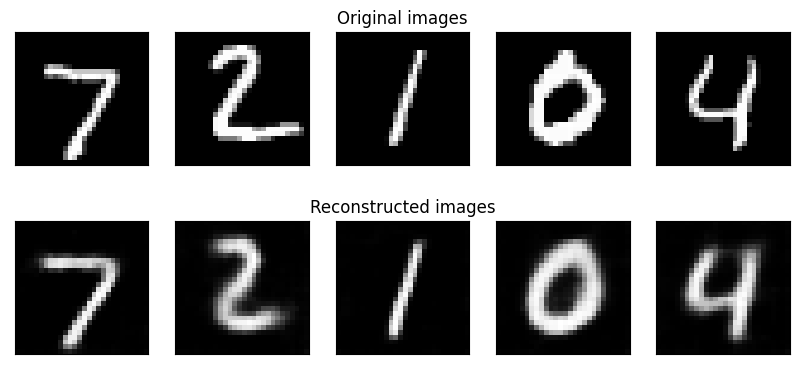

	 partial train loss (single batch): 0.025766
	 partial train loss (single batch): 0.026503
	 partial train loss (single batch): 0.028374
	 partial train loss (single batch): 0.027955
	 partial train loss (single batch): 0.026866
	 partial train loss (single batch): 0.025694
	 partial train loss (single batch): 0.028404
	 partial train loss (single batch): 0.027000
	 partial train loss (single batch): 0.025668
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.027076
	 partial train loss (single batch): 0.025774
	 partial train loss (single batch): 0.025629
	 partial train loss (single batch): 0.027389
	 partial train loss (single batch): 0.025837
	 partial train loss (single batch): 0.026971
	 partial train loss (single batch): 0.027867
	 partial train loss (single batch): 0.025839
	 partial train loss (single batch): 0.026604
	 partial train loss (single batch): 0.027058
	 partial train loss (single batch): 0.026793
	 partial train loss (single batch

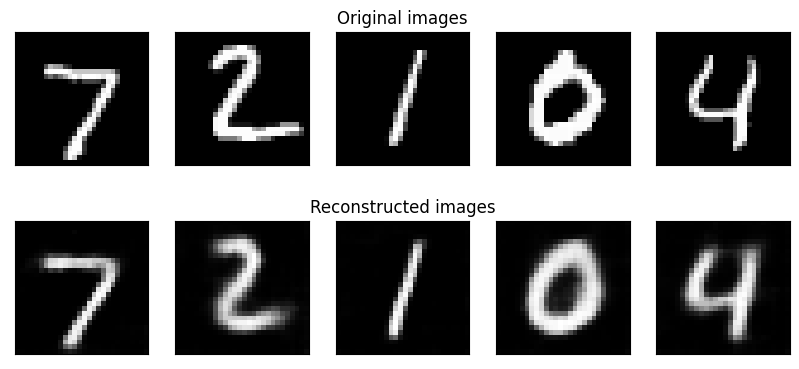

	 partial train loss (single batch): 0.025692
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.028362
	 partial train loss (single batch): 0.027896
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.028256
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.025509
	 partial train loss (single batch): 0.027796
	 partial train loss (single batch): 0.026928
	 partial train loss (single batch): 0.025658
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch): 0.027308
	 partial train loss (single batch): 0.025735
	 partial train loss (single batch): 0.026817
	 partial train loss (single batch): 0.027640
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.026409
	 partial train loss (single batch): 0.026988
	 partial train loss (single batch): 0.026737
	 partial train loss (single batch

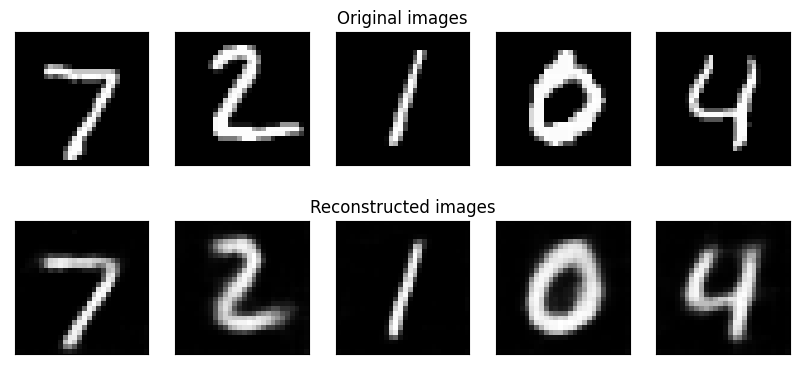

	 partial train loss (single batch): 0.025657
	 partial train loss (single batch): 0.026235
	 partial train loss (single batch): 0.028294
	 partial train loss (single batch): 0.027769
	 partial train loss (single batch): 0.026788
	 partial train loss (single batch): 0.025494
	 partial train loss (single batch): 0.028152
	 partial train loss (single batch): 0.026936
	 partial train loss (single batch): 0.025395
	 partial train loss (single batch): 0.027769
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.025594
	 partial train loss (single batch): 0.025414
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.025706
	 partial train loss (single batch): 0.026692
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.025621
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.026944
	 partial train loss (single batch): 0.026673
	 partial train loss (single batch

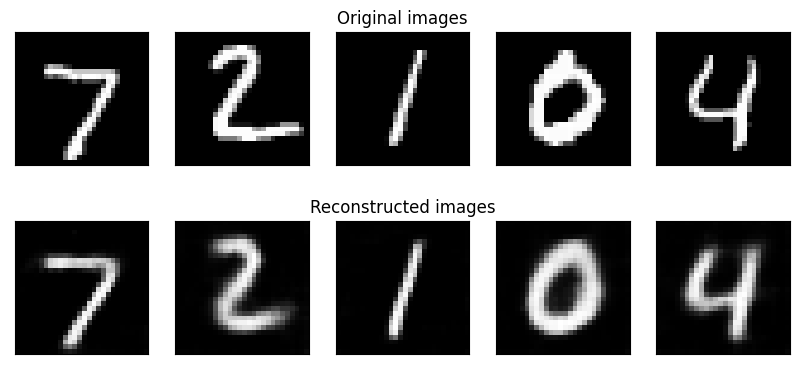

	 partial train loss (single batch): 0.025494
	 partial train loss (single batch): 0.026128
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.027614
	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.025341
	 partial train loss (single batch): 0.027951
	 partial train loss (single batch): 0.026780
	 partial train loss (single batch): 0.025410
	 partial train loss (single batch): 0.027549
	 partial train loss (single batch): 0.026694
	 partial train loss (single batch): 0.025544
	 partial train loss (single batch): 0.025317
	 partial train loss (single batch): 0.027134
	 partial train loss (single batch): 0.025650
	 partial train loss (single batch): 0.026578
	 partial train loss (single batch): 0.027546
	 partial train loss (single batch): 0.025550
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.026900
	 partial train loss (single batch): 0.026640
	 partial train loss (single batch

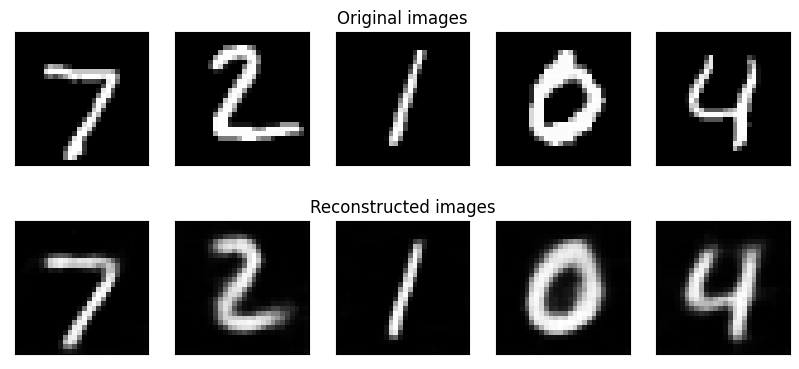

	 partial train loss (single batch): 0.025431
	 partial train loss (single batch): 0.026115
	 partial train loss (single batch): 0.028084
	 partial train loss (single batch): 0.027522
	 partial train loss (single batch): 0.026620
	 partial train loss (single batch): 0.025331
	 partial train loss (single batch): 0.027877
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.025323
	 partial train loss (single batch): 0.027524
	 partial train loss (single batch): 0.026621
	 partial train loss (single batch): 0.025496
	 partial train loss (single batch): 0.025270
	 partial train loss (single batch): 0.027072
	 partial train loss (single batch): 0.025630
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.027404
	 partial train loss (single batch): 0.025478
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.026949
	 partial train loss (single batch): 0.026562
	 partial train loss (single batch

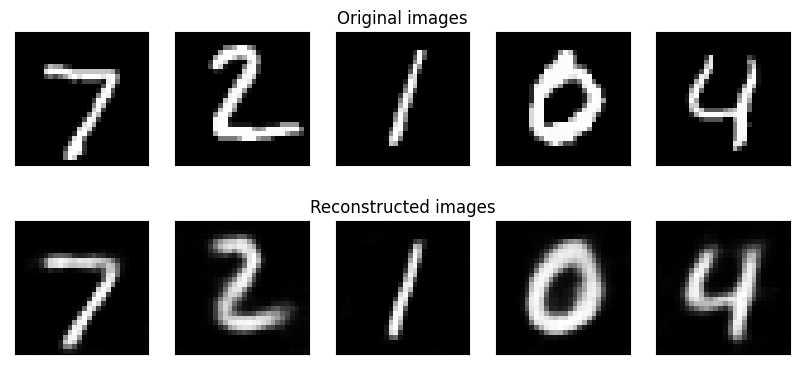

	 partial train loss (single batch): 0.025476
	 partial train loss (single batch): 0.026060
	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.027605
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.025326
	 partial train loss (single batch): 0.027841
	 partial train loss (single batch): 0.026641
	 partial train loss (single batch): 0.025354
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.025375
	 partial train loss (single batch): 0.025130
	 partial train loss (single batch): 0.026984
	 partial train loss (single batch): 0.025502
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.025341
	 partial train loss (single batch): 0.025976
	 partial train loss (single batch): 0.026876
	 partial train loss (single batch): 0.026519
	 partial train loss (single batch

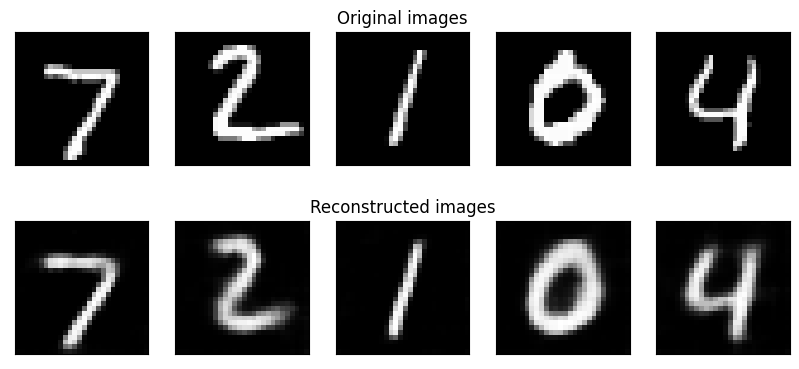

	 partial train loss (single batch): 0.025267
	 partial train loss (single batch): 0.025914
	 partial train loss (single batch): 0.027936
	 partial train loss (single batch): 0.027371
	 partial train loss (single batch): 0.026486
	 partial train loss (single batch): 0.025199
	 partial train loss (single batch): 0.027823
	 partial train loss (single batch): 0.026585
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.027374
	 partial train loss (single batch): 0.026490
	 partial train loss (single batch): 0.025244
	 partial train loss (single batch): 0.025020
	 partial train loss (single batch): 0.026913
	 partial train loss (single batch): 0.025428
	 partial train loss (single batch): 0.026472
	 partial train loss (single batch): 0.027405
	 partial train loss (single batch): 0.025299
	 partial train loss (single batch): 0.025927
	 partial train loss (single batch): 0.026790
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch

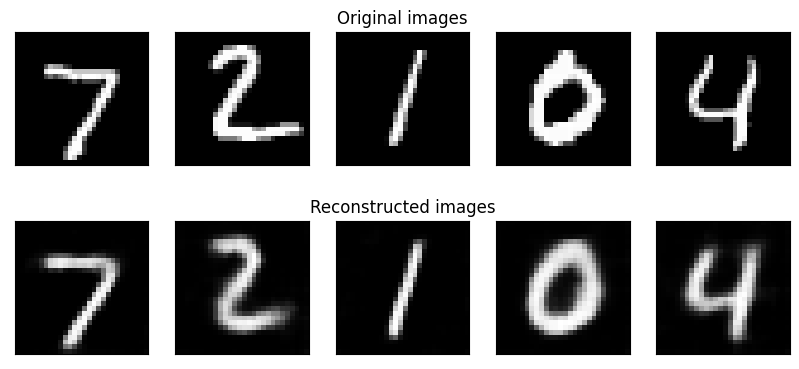

In [14]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

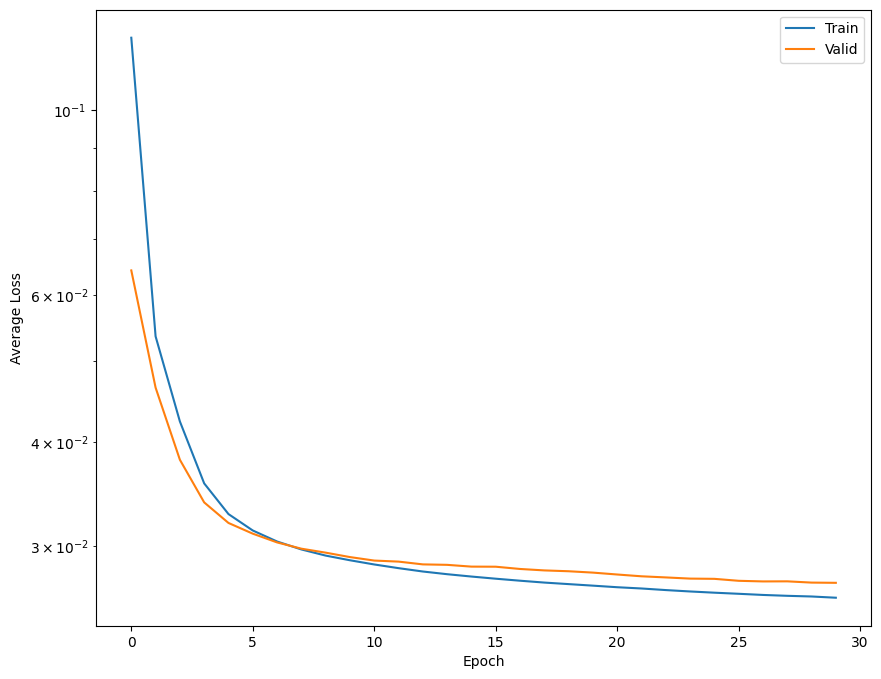

In [15]:
# Plot training performance
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4. Visualize Latent Space 

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2066.85it/s]


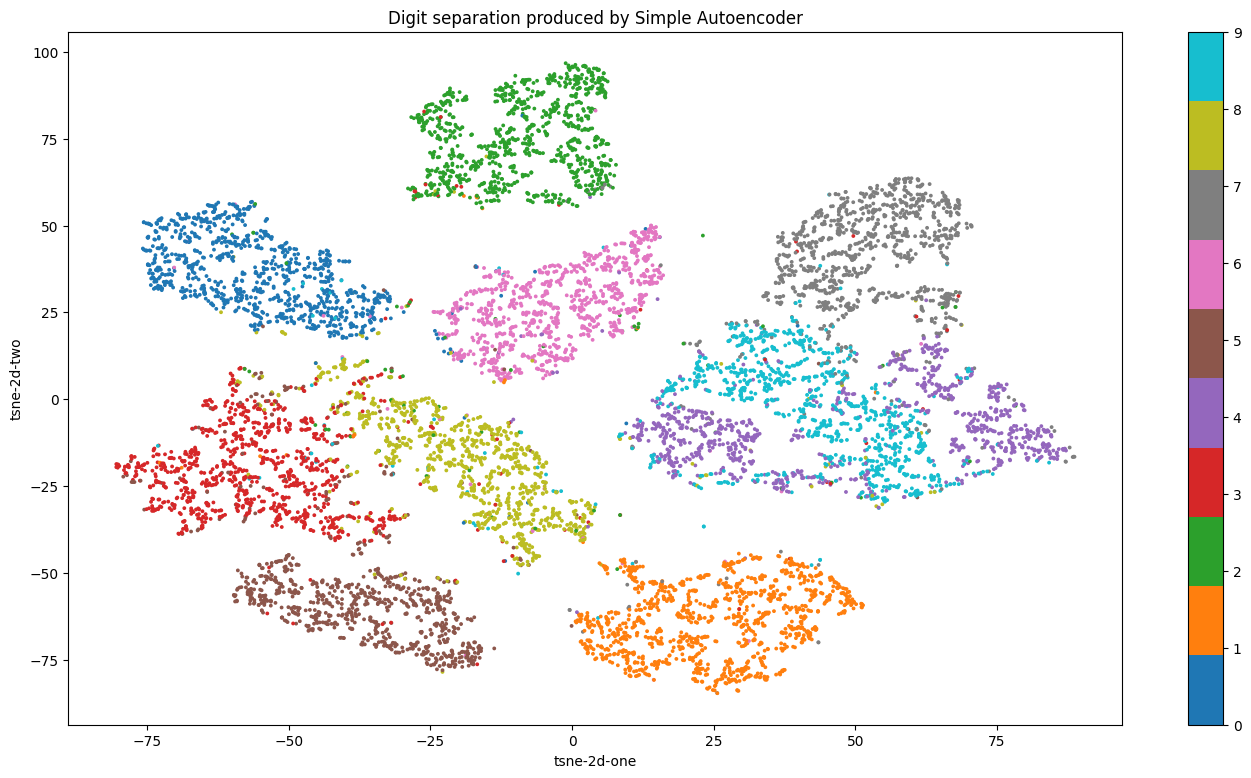

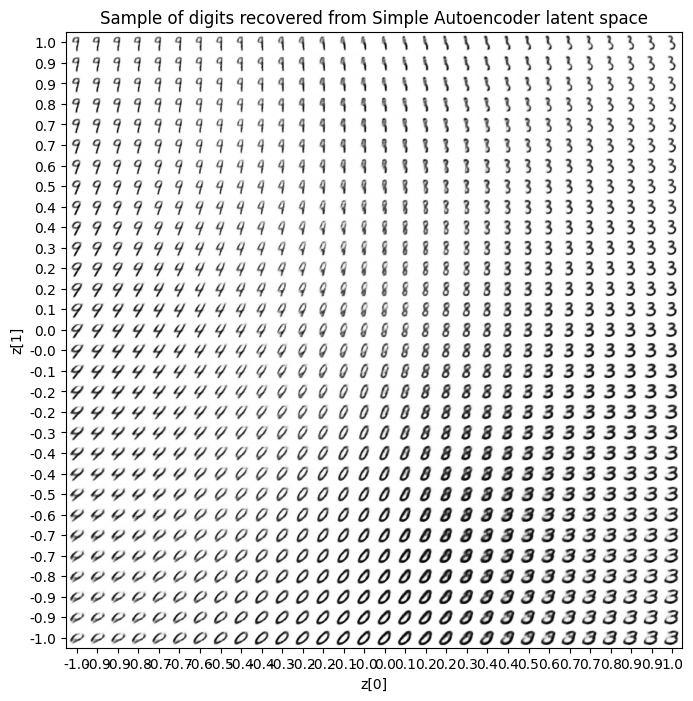

In [16]:
def plot_results(encoder, decoder, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    plt.show()

plot_results(encoder, decoder, test_dataset, rx=(-1, 1), ry=(-1, 1), model_name="Simple Autoencoder")

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table